In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [ ]:
!pip install contractions
import contractions

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.8/110.8 kB 15.2 MB/s eta 0:00:00


In [ ]:
from wordcloud import WordCloud
from gensim.models import Word2Vec

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [ ]:
from sklearn.model_selection import train_test_split
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Bidirectional, GlobalMaxPool1D, Dense, LSTM, Conv1D, Embedding

from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

from sklearn.metrics import accuracy_score, f1_score

In [ ]:
def text_data(data_lines, label_cat):
  text = []
  label = []
  revws = 1
  if label_cat == 'neg':
    revws = 0
  review = []
  for line in data_lines:
    # text.append(line.split('\n')[0])
    # label.append(revws)
    review.append(line.split('\n')[0])
    if '!' in line.split('\n')[0]:
      text.append(review)
      label.append(revws)
      review = []
  return text, label

In [ ]:
with open('/content/drive/MyDrive/Colab Notebooks/yelp_data/1000.pos', 'r') as f:
  pos_train = f.readlines()

In [ ]:
len(pos_train)

1000

In [ ]:
pos_train_text_1000, pos_train_label_1000 = text_data(pos_train, 'pos')

In [ ]:
len(pos_train_text_1000), len(pos_train_label_1000)

(241, 241)

In [ ]:
with open('/content/drive/MyDrive/Colab Notebooks/yelp_data/100.pos', 'r') as f:
  pos_train = f.readlines()

In [ ]:
len(pos_train)

100

In [ ]:
pos_train_text_100, pos_train_label_100 = text_data(pos_train, 'pos')

In [ ]:
len(pos_train_text_100), len(pos_train_label_100)

(33, 33)

In [ ]:
pos_train_text_1000.extend(pos_train_text_100)

In [ ]:
pos_train_label_1000.extend(pos_train_label_100)

In [ ]:
len(pos_train_text_1000), len(pos_train_label_1000)

(274, 274)

In [ ]:
pos_df = pd.DataFrame({'text':pos_train_text_1000, 'label':pos_train_label_1000})

In [ ]:
pos_df.head()

,text,label
0,[cashiers are nice and there are good deals he...,1
1,[i thought the owners were trustworthy and gen...,1
2,[they are very professional and a top notch je...,1
3,"[so happy ., honest all the way ., i highly re...",1
4,"[the ideal place for any dog ., staffed 24/7 w...",1


In [ ]:
with open('/content/drive/MyDrive/Colab Notebooks/yelp_data/1000.neg', 'r') as f:
  neg_train = f.readlines()

In [ ]:
neg_train_text_1000, neg_train_label_1000 = text_data(neg_train, 'neg')

In [ ]:
len(neg_train_text_1000), len(neg_train_label_1000)

(84, 84)

In [ ]:
with open('/content/drive/MyDrive/Colab Notebooks/yelp_data/100.neg', 'r') as f:
  neg_train = f.readlines()

In [ ]:
neg_train_text_100, neg_train_label_100 = text_data(neg_train, 'neg')

In [ ]:
len(neg_train_text_100), len(neg_train_label_100)

(15, 15)

In [ ]:
neg_train_text_1000.extend(neg_train_text_100)

In [ ]:
neg_train_label_1000.extend(neg_train_label_100)

In [ ]:
len(neg_train_text_1000), len(neg_train_label_1000)

(99, 99)

In [ ]:
neg_df = pd.DataFrame({'text':neg_train_text_1000, 'label':neg_train_label_1000})

In [ ]:
neg_df.head(5)

,text,label
0,"[the answer was none ., this place sucks ., we...",0
1,"[the italian sausage and peppers , however , w...",0
2,"[they do n't seem to care either ., sorry spin...",0
3,[thats just not italian !],0
4,[the bad service of the waitresses make me dre...,0


In [ ]:
train_df = pd.concat([pos_df[:90], neg_df[:90]], ignore_index=True)

In [ ]:
# val_df = pd.concat([pos_df[80:90], neg_df[80:90]], ignore_index=True)

In [ ]:
test_df = pd.concat([pos_df[90:], neg_df[90:]], ignore_index=True)

In [ ]:
train_df = train_df.sample(frac=1).reset_index(drop=True)
# val_df = val_df.sample(frac=1).reset_index(drop=True)
test_df = test_df.sample(frac=1).reset_index(drop=True)

In [ ]:
train_df.head()

,text,label
0,"[no wonder you have no customers ., do n't was...",0
1,[it 's worth the drive to really see nature at...,1
2,[they are very professional and a top notch je...,1
3,[they just have new owners and they are the ni...,1
4,[always unleashed is the best boarding facilit...,1


In [ ]:
# val_df.head()

In [ ]:
test_df.head()

,text,label
0,[they were all tasty !],1
1,[good food ... and all around good place to ha...,1
2,[see you here !],1
3,"[this place was pretty kick ass ., they have a...",1
4,"[loved , loved the oatmeal stout ., it was sli...",1


In [ ]:
train_df['label'].value_counts()

0    90
1    90
Name: label, dtype: int64

In [ ]:
# val_df['label'].value_counts()

In [ ]:
test_df['label'].value_counts()

1    184
0      9
Name: label, dtype: int64

In [ ]:
import re

def preprocessing_text(text):
  text = ' '.join(text)
  text = re.sub(r" n't", "n't", text)
  # text = re.sub(r"!", "", text)
  text = contractions.fix(text)
  text = text.lower()
  text = re.sub(r'[\d!@#$%^&*()_+{}\[\]:;"\'<>,.?/\\|`~=~-]', '', text)
  return text.strip()

In [ ]:
train_df['text'][2]

['they are very professional and a top notch jeweler .',
 'you will be in good hands .',
 'great place to go for watch and jewelry repairs .',
 'they also have nice selection of vintage jewelry .',
 'after three decades of watch buying i found a home !']

In [ ]:
train_df['text'] = train_df['text'].apply(lambda x : preprocessing_text(x))

In [ ]:
train_df['text'][2]

'they are very professional and a top notch jeweler  you will be in good hands  great place to go for watch and jewelry repairs  they also have nice selection of vintage jewelry  after three decades of watch buying i found a home'

In [ ]:
# val_df['text'] = val_df['text'].apply(lambda x : preprocessing_text(x))

In [ ]:
test_df['text'] = test_df['text'].apply(lambda x : preprocessing_text(x))

In [ ]:
pos = train_df[train_df['label']==1]['text']
neg = train_df[train_df['label']==0]['text']

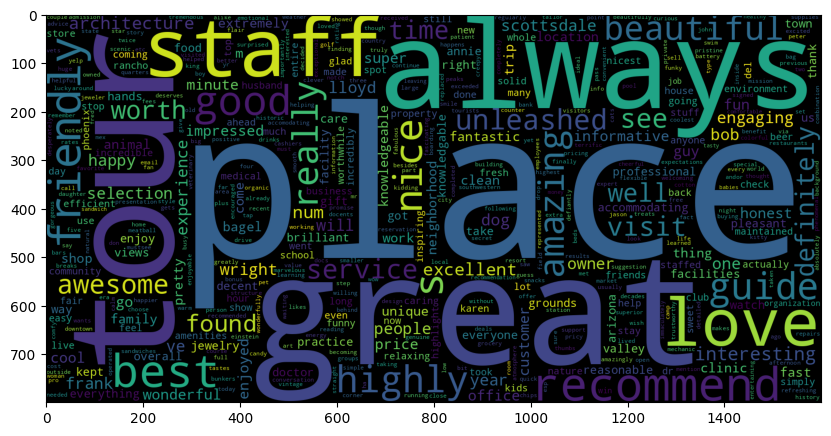

In [ ]:
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800,
              collocations=False).generate(' '.join(pos.to_list()))
plt.figure(figsize = (10,8))
plt.imshow(wc)

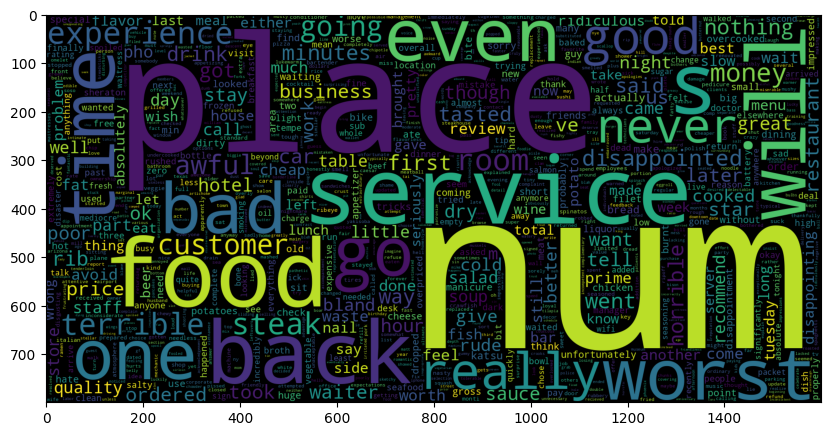

In [ ]:
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800,
              collocations=False).generate(' '.join(neg.to_list()))
plt.figure(figsize = (10,8))
plt.imshow(wc)

In [ ]:
# X_data, y_data = np.array(df['text']), np.array(df['label'])

# X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size = 0.10, random_state = 0)

#Word2Vec #

In [ ]:
X_train, y_train = np.array(train_df['text']), np.array(train_df['label'])
# X_val, y_val = np.array(val_df['text']), np.array(val_df['label'])
X_test, y_test = np.array(test_df['text']), np.array(test_df['label'])

In [ ]:
X_data = pd.concat([train_df['text'], test_df['text']], ignore_index=True) # val_df['text']

In [ ]:
X_data.head()

0    no wonder you have no customers  do not waste ...
1    it s worth the drive to really see nature at i...
2    they are very professional and a top notch jew...
3    they just have new owners and they are the nic...
4    always unleashed is the best boarding facility...
Name: text, dtype: object

In [ ]:
X_data.shape

(373,)

In [ ]:
Embedding_dim = 100

In [ ]:
train_w2v = list(map(lambda x: x.split(), X_train))

In [ ]:
word2vec_model = Word2Vec(train_w2v,
                 vector_size=Embedding_dim,
                 workers=8,
                 min_count=1)

In [ ]:
len(word2vec_model.wv.key_to_index)

1925

In [ ]:
max_len = 60
vocab_length = 2500

tokenizer = Tokenizer(filters="", lower=False, oov_token="<oov>")
tokenizer.fit_on_texts(X_data)
tokenizer.num_words = vocab_length

In [ ]:
X_train = pad_sequences(tokenizer.texts_to_sequences(X_train), maxlen=max_len)
# X_val  = pad_sequences(tokenizer.texts_to_sequences(X_val) , maxlen=max_len)
X_test  = pad_sequences(tokenizer.texts_to_sequences(X_test) , maxlen=max_len)

print("X_train.shape:", X_train.shape)
# print("X_val.shape :", X_val.shape)
print("X_test.shape :", X_test.shape)

In [ ]:
embedding_matrix = np.zeros((vocab_length, Embedding_dim))

for word, token in tokenizer.word_index.items():
    if word2vec_model.wv.__contains__(word):
        embedding_matrix[token] = word2vec_model.wv.__getitem__(word)

print("Embedding Matrix Shape:", embedding_matrix.shape)

Embedding Matrix Shape: (2500, 100)


In [ ]:
embedding_layer = Embedding(input_dim = vocab_length,
                                output_dim = Embedding_dim,
                                weights=[embedding_matrix],
                                input_length=max_len,
                                trainable=False)

In [ ]:
model = Sequential()
model.add(embedding_layer)
model.add(Bidirectional(LSTM(100, dropout=0.3)))
model.add(Dense(16, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 60, 100)           250000    
                                                                 
 bidirectional_2 (Bidirecti  (None, 200)               160800    
 onal)                                                           
                                                                 
 dense_4 (Dense)             (None, 16)                3216      
                                                                 
 dense_5 (Dense)             (None, 1)                 17        
                                                                 
Total params: 414033 (1.58 MB)
Trainable params: 164033 (640.75 KB)
Non-trainable params: 250000 (976.56 KB)
_________________________________________________________________


In [ ]:
callbacks = [ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
             EarlyStopping(monitor='val_accuracy', min_delta=1e-4, patience=5)]

In [ ]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
history = model.fit(
    X_train, y_train,
    batch_size=32,
    epochs=12,
    validation_split=0.1,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/12
6/6 [==============================] - 8s 422ms/step - loss: 0.6736 - accuracy: 0.6358 - val_loss: 0.6673 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 2/12
6/6 [==============================] - 1s 126ms/step - loss: 0.6335 - accuracy: 0.6111 - val_loss: 0.7091 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 3/12
6/6 [==============================] - 0s 76ms/step - loss: 0.6075 - accuracy: 0.6852 - val_loss: 0.7883 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 4/12
6/6 [==============================] - 1s 98ms/step - loss: 0.6065 - accuracy: 0.6852 - val_loss: 0.7859 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 5/12
6/6 [==============================] - 1s 97ms/step - loss: 0.6076 - accuracy: 0.6790 - val_loss: 0.7557 - val_accuracy: 0.4444 - lr: 0.0010
Epoch 6/12
6/6 [==============================] - 1s 90ms/step - loss: 0.6263 - accuracy: 0.6852 - val_loss: 0.7144 - val_accuracy: 0.5000 - lr: 0.0010


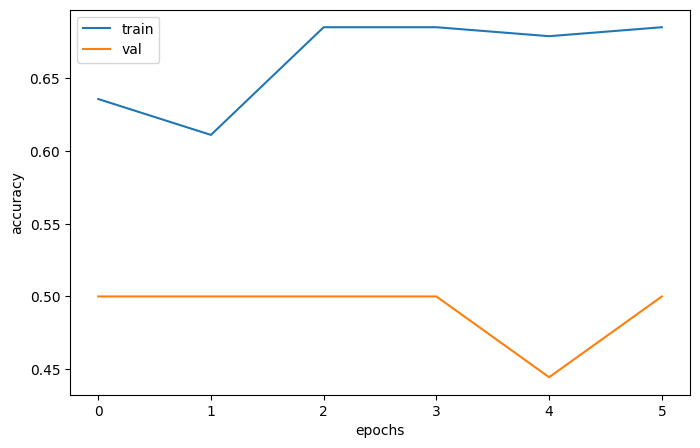

In [ ]:
plt.figure(figsize=(8,5))
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='val')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

In [ ]:
y_pred = (model.predict(X_test)> 0.5).astype(int)

7/7 [==============================] - 1s 22ms/step


In [ ]:
accuracy_score(y_pred, y_test)

0.8031088082901554

In [ ]:
f1_score(y_pred, y_test)

0.8895348837209303

#BERT#

In [ ]:
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 30.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 32.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 78.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 71.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 34.0 MB/s eta 0:00:00


In [ ]:
import transformers
import tensorflow as tf
from transformers import BertModel, BertTokenizer
from transformers import TFAutoModel

In [ ]:
seq_len = 60
num_samples = len(train_df)
num_samples, seq_len

(180, 60)

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

In [ ]:
tokens = tokenizer(train_df['text'].to_list(), max_length=seq_len,
                  truncation=True, padding='max_length',
                  add_special_tokens=True,
                  return_tensors='np')

In [ ]:
tokens['input_ids'].shape, tokens['attention_mask'].shape

((180, 60), (180, 60))

In [ ]:
arr = train_df['label'].values

In [ ]:
labels = np.zeros((num_samples, arr.max()+1))
labels.shape

(180, 2)

In [ ]:
labels[np.arange(num_samples), arr] = 1

In [ ]:
labels.shape

(180, 2)

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices((tokens['input_ids'], tokens['attention_mask'], labels))

In [ ]:
train_dataset.take(1)

<_TakeDataset element_spec=(TensorSpec(shape=(60,), dtype=tf.int64, name=None), TensorSpec(shape=(60,), dtype=tf.int64, name=None), TensorSpec(shape=(2,), dtype=tf.float64, name=None))>

In [ ]:
def fun_map(input_ids, masks, labels):
  return {'input_ids':input_ids, 'attention_mask':masks}, labels

In [ ]:
train_dataset = train_dataset.map(fun_map)

In [ ]:
train_dataset.take(1)

<_TakeDataset element_spec=({'input_ids': TensorSpec(shape=(60,), dtype=tf.int64, name=None), 'attention_mask': TensorSpec(shape=(60,), dtype=tf.int64, name=None)}, TensorSpec(shape=(2,), dtype=tf.float64, name=None))>

In [ ]:
batch_size = 16

In [ ]:
train_dataset = train_dataset.shuffle(100).batch(batch_size, drop_remainder=True)

In [ ]:
split = 0.9
size = int((tokens['input_ids'].shape[0]/batch_size)*split)

In [ ]:
train_ds = train_dataset.take(size)
val_ds = train_dataset.skip(size)

In [ ]:
bert = TFAutoModel.from_pretrained('bert-base-cased')

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [ ]:
bert.summary()

Model: "tf_bert_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  108310272 
                                                                 
Total params: 108310272 (413.17 MB)
Trainable params: 108310272 (413.17 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
input_ids = tf.keras.layers.Input(shape=(60,), name='input_ids', dtype='int64')
mask = tf.keras.layers.Input(shape=(60,), name='attention_mask', dtype='int64')

embeddings = bert.bert(input_ids, attention_mask=mask)[1]

x = tf.keras.layers.Dense(1024, activation='relu')(embeddings)
y = tf.keras.layers.Dense(2, activation='sigmoid', name='outputs')(x)

In [ ]:
model = tf.keras.Model(inputs=[input_ids, mask], outputs=y)

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_ids (InputLayer)      [(None, 60)]                 0         []                            
                                                                                                  
 attention_mask (InputLayer  [(None, 60)]                 0         []                            
 )                                                                                                
                                                                                                  
 bert (TFBertMainLayer)      TFBaseModelOutputWithPooli   1083102   ['input_ids[0][0]',           
                             ngAndCrossAttentions(last_   72         'attention_mask[0][0]']      
                             hidden_state=(None, 60, 76                                       

In [ ]:
model.layers[2].trainable=False

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_ids (InputLayer)      [(None, 60)]                 0         []                            
                                                                                                  
 attention_mask (InputLayer  [(None, 60)]                 0         []                            
 )                                                                                                
                                                                                                  
 bert (TFBertMainLayer)      TFBaseModelOutputWithPooli   1083102   ['input_ids[0][0]',           
                             ngAndCrossAttentions(last_   72         'attention_mask[0][0]']      
                             hidden_state=(None, 60, 76                                       

In [ ]:
optimizer = tf.keras.optimizers.Adam()
loss = tf.keras.losses.CategoricalCrossentropy()
acc = tf.keras.metrics.CategoricalAccuracy('accuracy')

model.compile(optimizer=optimizer, loss=loss, metrics=[acc])

In [ ]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=12,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/12
10/10 [==============================] - 48s 5s/step - loss: 0.3899 - accuracy: 0.8438 - val_loss: 0.4610 - val_accuracy: 0.8125 - lr: 0.0010
Epoch 2/12
10/10 [==============================] - 41s 4s/step - loss: 0.4398 - accuracy: 0.7875 - val_loss: 0.5370 - val_accuracy: 0.6250 - lr: 0.0010
Epoch 3/12
10/10 [==============================] - 39s 4s/step - loss: 0.4041 - accuracy: 0.8313 - val_loss: 0.5514 - val_accuracy: 0.6875 - lr: 0.0010
Epoch 4/12
10/10 [==============================] - 40s 4s/step - loss: 0.3503 - accuracy: 0.8625 - val_loss: 0.4596 - val_accuracy: 0.8750 - lr: 0.0010
Epoch 5/12
10/10 [==============================] - 39s 4s/step - loss: 0.3461 - accuracy: 0.8500 - val_loss: 0.2478 - val_accuracy: 0.9375 - lr: 0.0010
Epoch 6/12
10/10 [==============================] - 39s 4s/step - loss: 0.3363 - accuracy: 0.8687 - val_loss: 0.2007 - val_accuracy: 0.9375 - lr: 0.0010
Epoch 7/12
10/10 [==============================] - 39s 4s/step - loss: 0.3704 - a

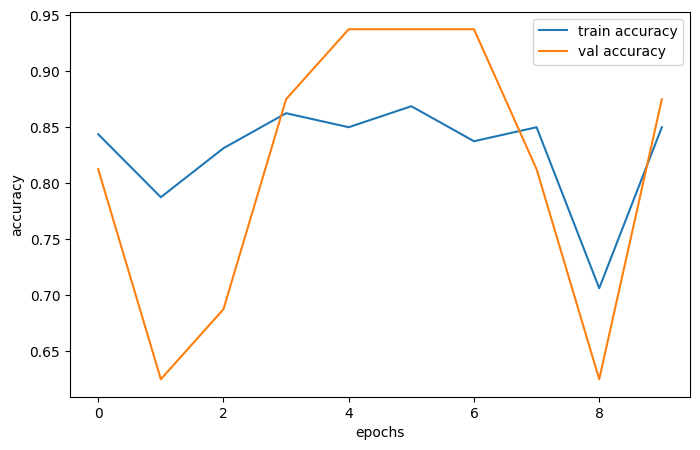

In [ ]:
plt.figure(figsize=(8,5))
plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

In [ ]:
test_tokens = tokenizer(test_df['text'].to_list(), max_length=seq_len,
                  truncation=True, padding='max_length',
                  add_special_tokens=True,
                  return_tensors='np')

In [ ]:
test_tokens['input_ids'].shape, test_tokens['attention_mask'].shape

((193, 60), (193, 60))

In [ ]:
test_dataset = {'input_ids':test_tokens['input_ids'], 'attention_mask':test_tokens['attention_mask']}

In [ ]:
predictions = model.predict(test_dataset)

7/7 [==============================] - 41s 5s/step


In [ ]:
y_pred = []
for i in range(len(predictions)):
  y_pred.append(np.argmax(predictions[i]))

In [ ]:
len(y_pred)

193

In [ ]:
test_arr = test_df['label'].values

In [ ]:
test_labels = np.zeros((len(test_df), test_arr.max()+1))
test_labels.shape

(193, 2)

In [ ]:
test_labels[np.arange(len(test_df)), test_arr] = 1

In [ ]:
accuracy_score(y_pred, test_arr)

0.9481865284974094

In [ ]:
f1_score(y_pred, test_arr)

0.9728260869565217

In [ ]:
text = 'the food is good'

_tokens = tokenizer(text, max_length=seq_len,
                  truncation=True, padding='max_length',
                  add_special_tokens=True,
                  return_tensors='np')
x = {'input_ids':_tokens['input_ids'], 'attention_mask':_tokens['attention_mask']}

model.predict(x)

1/1 [==============================] - 0s 425ms/step


array([[0.12963906, 0.8926615 ]], dtype=float32)